### import dependencies

In [1]:
import h5py
import numpy as np
import pandas as pd
from tkinter import *
from tkinter import filedialog
from tqdm import notebook
import matplotlib.pyplot as plt

### gui pop-up for loading multiple h5 files at once

In [2]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
h5_files = filedialog.askopenfilename(multiple=True, title='load facemap h5')

%gui tk

2023-02-10 09:54:21.969 python[34519:1459617] +[CATransaction synchronize] called within transaction


### reorganize h5 format into dataframe

In [4]:
# initialize a list for storing all dataframes
data_dicts = []
selected_fnames = [h5_files[i].rpartition("/")[2] for i in range(len(h5_files))]
# for each h5 file you uploaded
for f, h5_file in enumerate(h5_files):
    print(50*'=')
    print(f'working on file {selected_fnames[f]}...')
    h5_df = h5py.File(h5_file, 'r')
    # create a dictionary for organization
    data_dict_bps = dict()
    # iterate through body parts, total was 15 keypoints
    keypoint_num = len(h5_df['Facemap'].keys())
    print(50*'-')
    print(f'going through all {keypoint_num} keypoints...')
    for bodypart in notebook.tqdm(h5_df['Facemap'].keys()):
        # iterate through frames
        data_dict_bp = dict()
        for frame in notebook.tqdm(range(len(h5_df['Facemap'][bodypart]['x']))):
            data_dict_bp[frame] = {'frame': frame,
                                'key': bodypart,
                                'x': h5_df['Facemap'][bodypart]['x'][frame],
                                'y': h5_df['Facemap'][bodypart]['y'][frame],
                                'likelihood': h5_df['Facemap'][bodypart]['likelihood'][frame]}
        data_dict_bps[bodypart] = data_dict_bp
    # append for all h5 files
    data_dicts.append(data_dict_bps)

working on file W4_020123_FacemapPose.h5...
--------------------------------------------------
going through all 15 keypoints...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

  0%|          | 0/401557 [00:00<?, ?it/s]

### save dataframes as csv

In [5]:
# for all h5 files
for f in range(len(data_dicts)):
    # iterate through all keypoints and save as individual csv files
    for bodypart in notebook.tqdm(h5_df['Facemap'].keys()):
        # convert into dataframe,
        # transpose to make frame x features (keypoint, x, y, likelihood)
        keypoint_df = pd.DataFrame(data=data_dicts[f][bodypart]).T
        keypoint_df.to_csv(f'../temp/{selected_fnames[f]}-{bodypart}.csv',
                           header=None)

  0%|          | 0/15 [00:00<?, ?it/s]

### get euclidean distance split by keypoints for 1 file

In [6]:
# select a file index
file_idx = 0
disp_bps = dict()
for bodypart in notebook.tqdm(h5_df['Facemap'].keys()):
    data_len = len(data_dicts[file_idx][bodypart])
    disp_bp = []
    for r in range(data_len-1):
        disp_bp.append(
            np.linalg.norm(
                np.array([data_dicts[file_idx][bodypart][r+1]['x'],
                          data_dicts[file_idx][bodypart][r+1]['y']]) -
                np.array([data_dicts[file_idx][bodypart][r]['x'],
                          data_dicts[file_idx][bodypart][r]['y']])
            )
        )
    disp_bps[bodypart] = np.hstack(disp_bp)

  0%|          | 0/15 [00:00<?, ?it/s]

### plot displacement per keypoint

In [7]:
# list out all keypoints
disp_bps.keys()

dict_keys(['eye(back)', 'eye(bottom)', 'eye(front)', 'eye(top)', 'lowerlip', 'mouth', 'nose(bottom)', 'nose(r)', 'nose(tip)', 'nose(top)', 'nosebridge', 'paw', 'whisker(I)', 'whisker(II)', 'whisker(III)'])

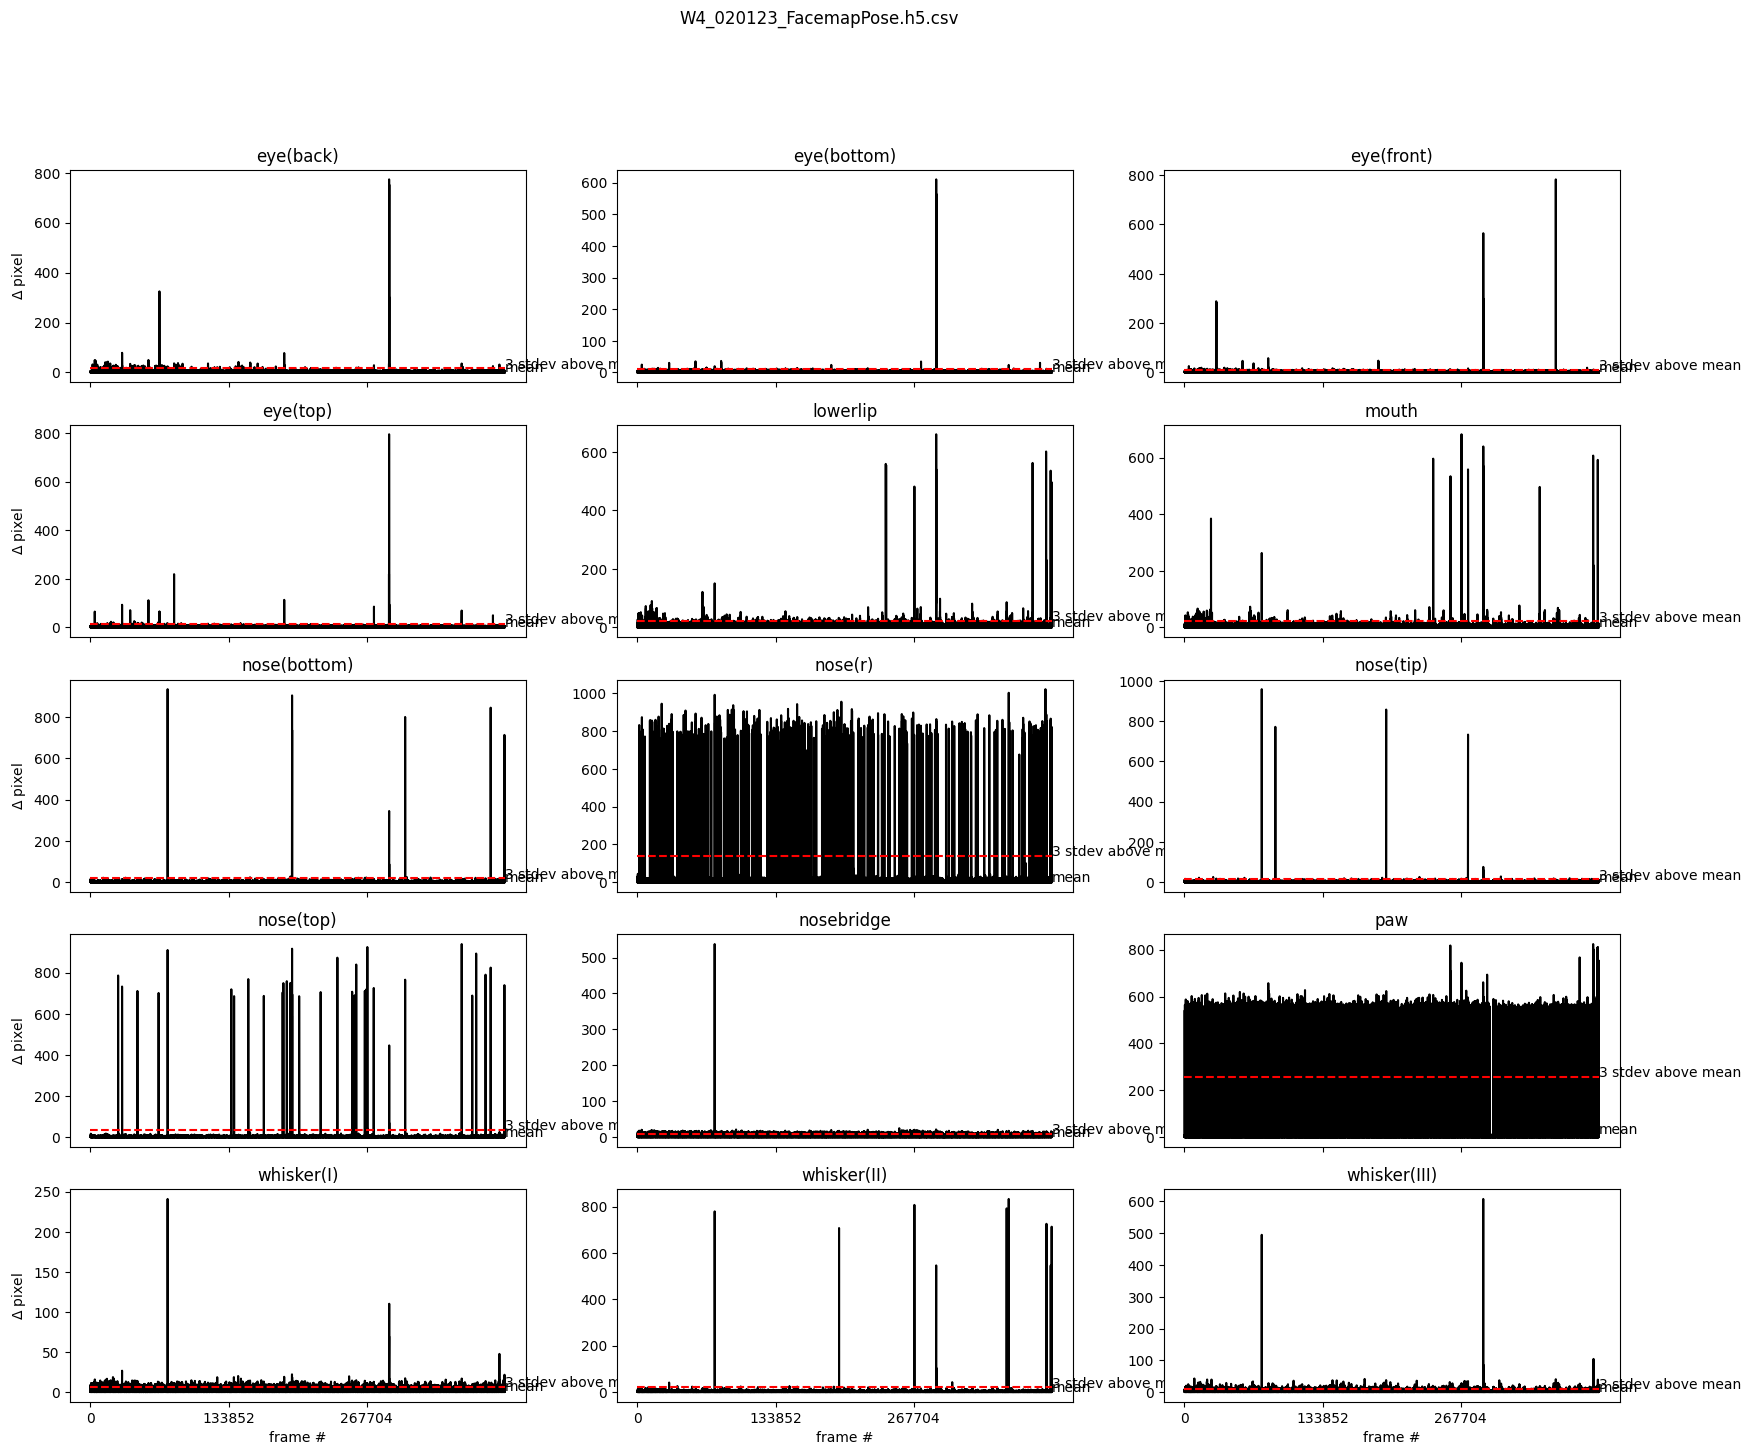

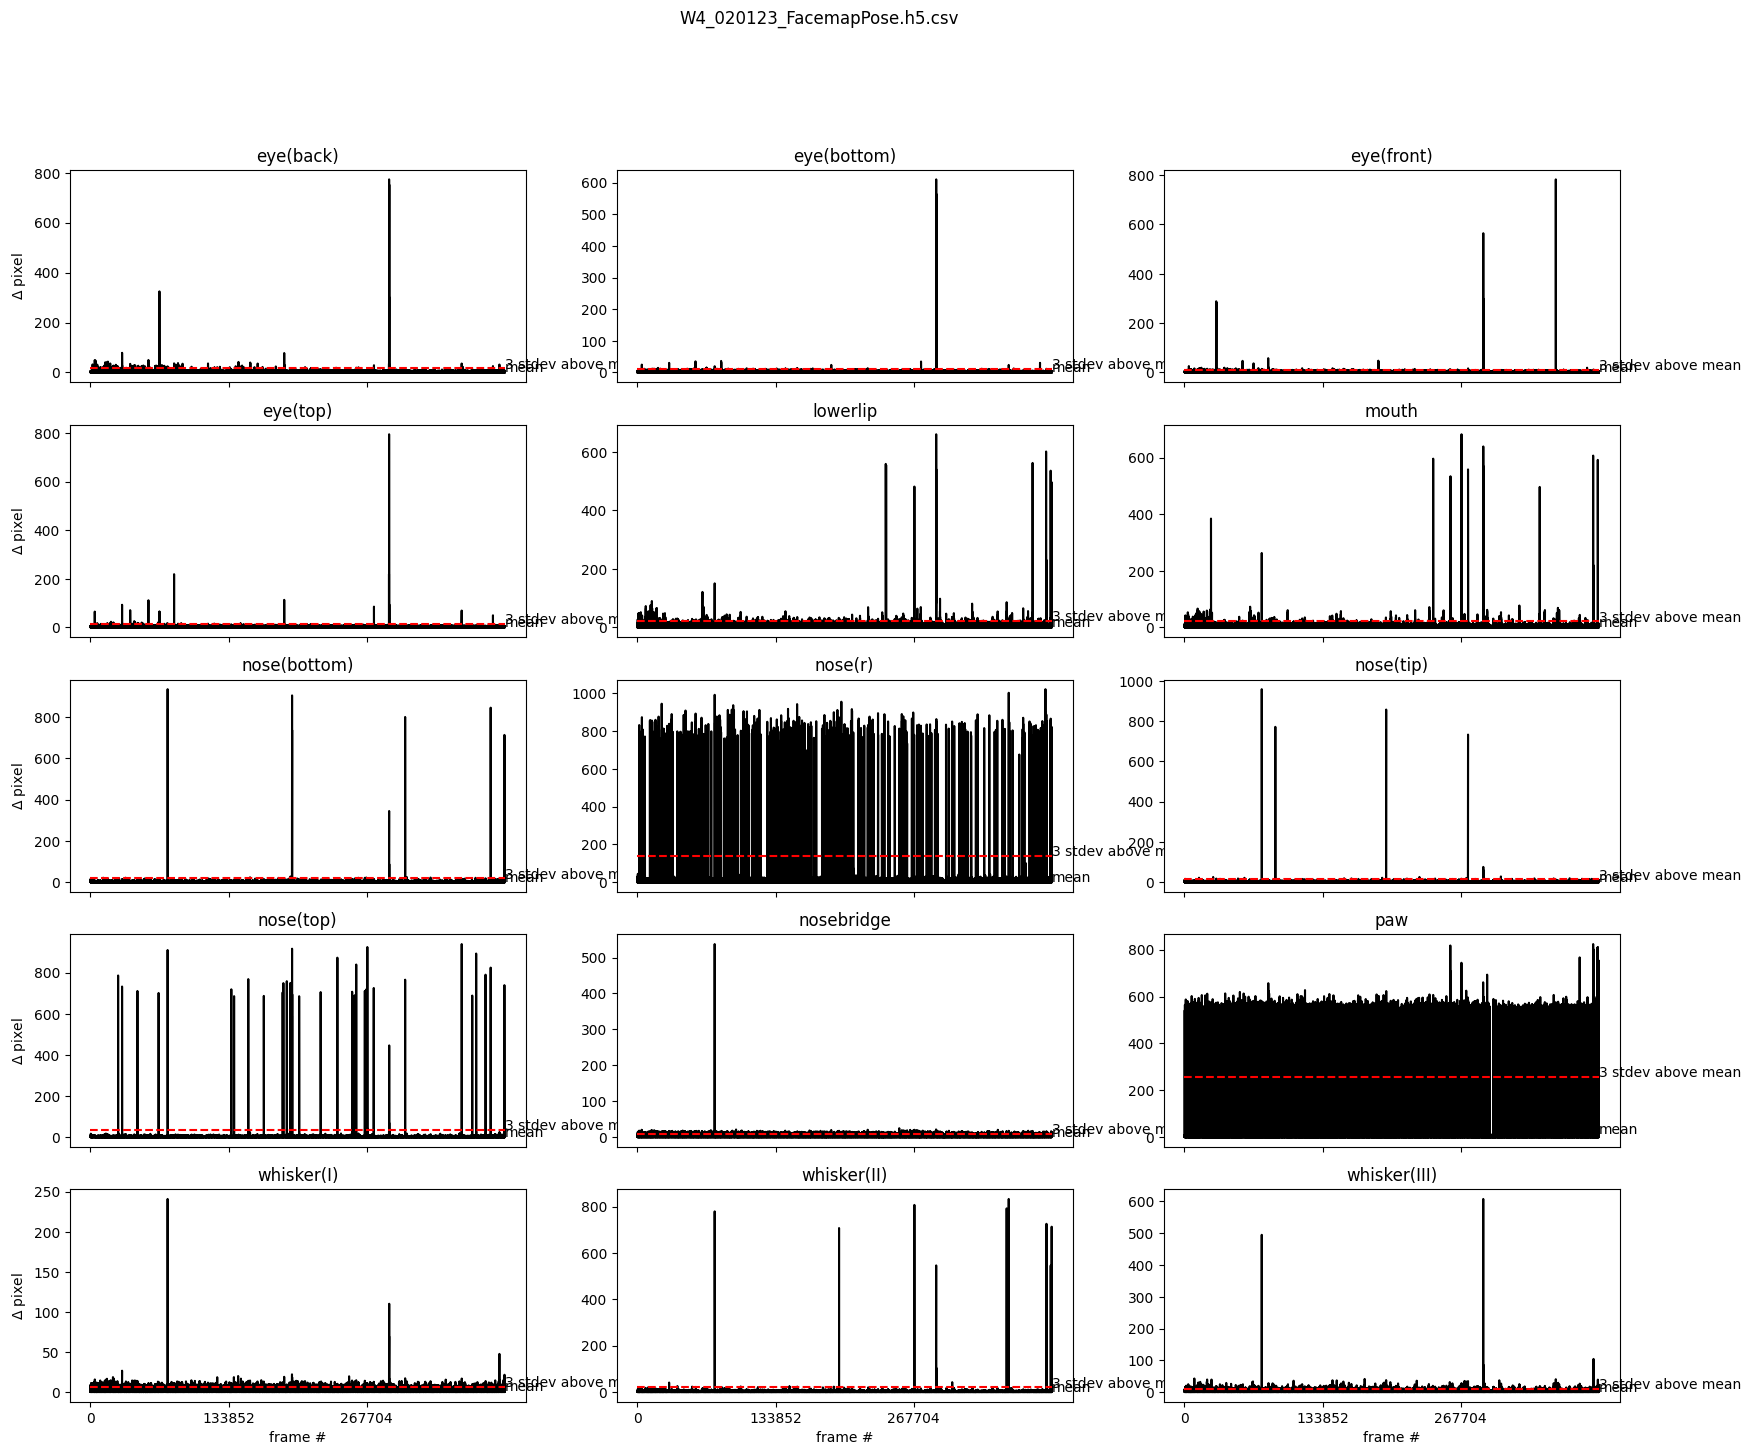

In [15]:
# select a file index
file_idx = 0
# create a 3x5 keypoint plot
rows = 5
cols = 3
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(20, 16), sharex=True)
fig.suptitle(f'{selected_fnames[file_idx]}.csv')
for row in range(rows):
    for col in range(cols):
        # mean displacement for this keypoint
        mean_disp = np.mean(disp_bps[list(disp_bps.keys())[count]])
        # stdev displacement for this keypoint
        std_disp = np.std(disp_bps[list(disp_bps.keys())[count]])
        # plot displacement
        ax[row, col].set_title(list(disp_bps.keys())[count])
        ax[row, col].plot(disp_bps[list(disp_bps.keys())[count]],
                          color='k')
        # line for mean
        ax[row, col].hlines(mean_disp, 0, len(disp_bps[list(disp_bps.keys())[count]]),
                            ls='--',
                            color='k')
        # text for mean
        ax[row, col].text(len(disp_bps[list(disp_bps.keys())[count]]),
                          (mean_disp)*1,
                          'mean')
        # line for mean + 3 stdev
        ax[row, col].hlines(mean_disp+3*std_disp,
                            0,
                            len(disp_bps[list(disp_bps.keys())[count]]),
                            ls='--',
                            color='r')
        # text for mean + 3 stdev
        ax[row, col].text(len(disp_bps[list(disp_bps.keys())[count]]),
                          (mean_disp+3*std_disp)*1,
                          '3 stdev above mean')
        # y label is delta pixel (per frame)
        if col == 0:
            ax[row, col].set_ylabel('$\Delta$ pixel')
        # x label is frame number
        if row == rows-1:
            ax[row, col].set_xlabel('frame #')
        ax[row, col].set_xticks(np.arange(0,
                                len(disp_bps[list(disp_bps.keys())[count]]),
                                len(disp_bps[list(disp_bps.keys())[count]])/3))
        count += 1
plt.show()
fig.savefig(f'../figs/{selected_fnames[file_idx]}_kp_euclidean.png', dpi=300)